In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df_x = pd.read_csv('./results/view_score/easier_view.csv', index_col=0)

In [3]:
df_y = pd.read_pickle('../../../00_data/ITRP.PATIENT.TABLE')
df_y1 = df_y[df_y.cohort != 'Gide']
df_y2 = df_y[df_y.cohort == 'Gide']
df_y2 = df_y2.set_index('rnaseq_id')
df_y = pd.concat([df_y1, df_y2])

In [4]:
df = df_x.join(df_y['response_label'])
df.columns

Index(['ccpairs', 'immunecells', 'lrpairs', 'pathways', 'tfs', 'cohort',
       'response_label'],
      dtype='object')

In [5]:
test_cohort = 'IMvigor210'

df_test = df[df.cohort == test_cohort]
df_train = df[df.cohort != test_cohort]

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 假设 df 已定义
# 前5列是特征，第6列是标签（'R' or 'NR'）

# 1. 准备数据
X = df_train[['ccpairs', 'immunecells', 'lrpairs', 'pathways', 'tfs']]
y = df_train[['response_label']]

# 2. 标签编码：'R' → 1, 'NR' → 0
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# # 3. 构建 Logistic Regression + 参数网格（含类别不平衡处理）
# lr = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],         # 正则化强度
#     'penalty': ['l1', 'l2']               # L1 / L2 正则项
# }

# 3. Construct Random Forest model with class_weight='balanced' for imbalanced data
lr = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

# Parameter grid for hyperparameter search
param_grid = {
    'n_estimators': [100, 200, 500],        # Number of trees
    'max_depth': [None, 5, 10, 20],         # Tree depth
    'min_samples_split': [2, 5, 10],        # Minimum samples to split
    'max_features': ['sqrt', 'log2']        # Feature selection strategy
}


# 4. 使用 stratified 交叉验证 + GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y_encoded)
best_params = grid_search.best_params_

# 5. 使用最佳参数重新训练逻辑回归模型
# Final model trained on full data
final_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    **best_params
)
final_model.fit(X, y_encoded)

# 6. 在全体数据上评估模型（训练集内评估）
y_pred = final_model.predict(X)
y_proba = final_model.predict_proba(X)[:, 1]

print("✅ Best parameters from CV:", best_params)
print("\n📋 Classification Report:\n", classification_report(y_encoded, y_pred, target_names=le.classes_))
print("📊 Confusion Matrix:\n", confusion_matrix(y_encoded, y_pred))
print("📈 ROC AUC Score (on full data):", roc_auc_score(y_encoded, y_proba))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ Best parameters from CV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}

📋 Classification Report:
               precision    recall  f1-score   support

          NR       0.81      0.80      0.81       557
           R       0.61      0.64      0.62       278

    accuracy                           0.74       835
   macro avg       0.71      0.72      0.71       835
weighted avg       0.75      0.74      0.75       835

📊 Confusion Matrix:
 [[444 113]
 [101 177]]
📈 ROC AUC Score (on full data): 0.8403639745295325


In [7]:
X_test = df_test[['ccpairs', 'immunecells', 'lrpairs', 'pathways', 'tfs']]
y_test = df_test[['response_label']]

test_y = final_model.predict_proba(X_test)[:, 1]

dfres = pd.DataFrame(test_y, columns = ['EASIER'], index = df_test.index)
dfres.to_csv('./EASIER_Leave_%s_out.csv' % test_cohort)

Test ROC AUC: 0.570


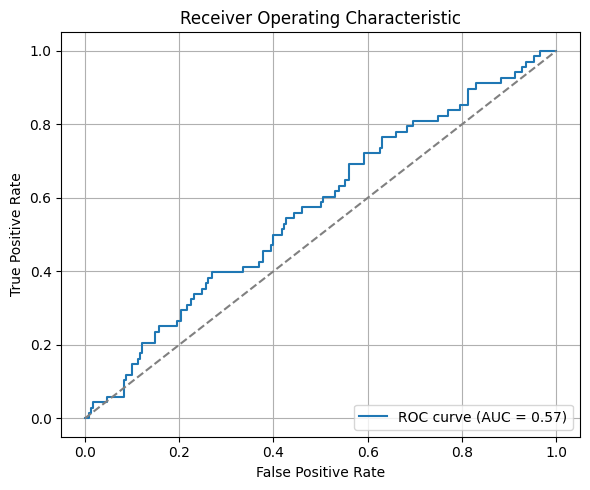

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binary labels: assume 'R' is positive
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test.values.ravel())  # 'R' → 1, 'NR' → 0

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test_bin, test_y)
roc_auc = auc(fpr, tpr)

# Print AUC score
print(f"Test ROC AUC: {roc_auc:.3f}")

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()